In [22]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Session, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import (
    TrivialLayout,
    BasicSwap,
    BasisTranslator
)
    

from qiskit_ibm_runtime.fake_provider import FakeKyiv, FakeBrisbane

from matplotlib import pyplot as plt
from datetime import datetime, timezone
import numpy as np
from numpy import linalg as la
from scipy.optimize import least_squares
import os, csv

# API tokens for IBM Quantum Platform. Updated on 04-Dec-2024.

## Account Information

### KQC_Pharmcadd
### ibm-q-kqc / pharcadd / research OR ibm-q / open / main
token = 'e2b36571a4a8ed3720a30c8d7b2d59b55347beebe48614832e74a156a3669e6179d306b2ff3727f08ef95b99c1166add2a774e80fff85405abe38a0da1eb1c8c'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

### my account: ichi@kaist
### ibm-q-skku / kaist / kaist-graduate OR ibm-q / open / main
token = '23b4b9e4f3507d73dd25691b5b96bc6a70ab7798ea6821b91db525151323338264a62e5adfff61edb604f62fcaa51a4484a54450bb239b8c52e8d1ccd76344c2'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

Usage limits (open): Monthly usage is limited up to 10 minutes, refreshes on the first of each month. At most 3 pending workloads at a time.

## Load QiskitRuntimeService

In [23]:
# Show the list of the saved accounts
saved_accounts = QiskitRuntimeService.saved_accounts()

#for key, value in saved_accounts.items():
#    print(key, value)

In [24]:
# Load account and generate QiskitRuntimeService
default_account = saved_accounts['kaist_ichi9505']
service = QiskitRuntimeService(channel=default_account['channel'],token=default_account['token'])

# Functions

In [59]:
# <name>: <type> = <default> -> <return_type>
def fun_zeroth_RB(x,A,p,B):
    return A * (p ** x) + B

def fun_first_RB(x,A,p,C,q,B):
    return A*(p**x) + C*(x-1)*(p**(x-2)) + B

def generate_RB_circuit(qc: QuantumCircuit, sequence: list[int], int_gate:int=None) -> QuantumCircuit:
    qc_rb = qc.copy_empty_like(name='C_RB')
    basis = {0:qc_rb.id,
            1:qc_rb.x,
            2:qc_rb.y,
            3:qc_rb.z,
            4:qc_rb.h,
            5:qc_rb.s,
            6:qc_rb.sdg}
    clif = {0:[0],
            1:[1],
            2:[2],
            3:[3],
            4:[4],
            5:[5],
            6:[6],
            7:[3,4],
            8:[4,1],
            9:[4,2],
            10:[4,3],
            11:[4,5],
            12:[4,6],
            13:[5,1],
            14:[5,2],
            15:[5,3],
            16:[5,4],
            17:[6,1],
            18:[6,2],
            19:[6,3],
            20:[6,4],
            21:[5,4,1],
            22:[5,4,3],
            23:[6,4,2]}
    for g in sequence:
        #print(clif[g])
        for cg in clif[g]:
            basis[cg](0)
        if int_gate is None:
            pass
        else:
            basis[int_gate](0)
            
    return qc_rb    

def generate_random_sequences(num_seqs: int, max_length_seq: int) -> list[int]:
    rng = np.random.default_rng()
    return rng.integers(0, high=24, size=(num_seqs, max_length_seq))

def generate_inverse_circuit(qc:QuantumCircuit, int_gate:str=None) -> QuantumCircuit:
    qc_inv = qc.copy(name='C_inv')
    return qc_inv.inverse()

## conduct quantum experiments on ibm backend : Randomized Benchmarking

In [90]:
#backend = FakeKyiv()
backend = service.least_busy() #get_backend('ibm_strasbourg') #least_busy()
print(f'The chosen backend: {backend.name}')

basis_gates = [instruction for instruction in backend.configuration().supported_instructions if len(instruction) < 5]
print(f'The basis_gates of {backend.name}: {basis_gates}')

target_qubit = 27

d = 2
num_seqs = 15
max_length_seq = 96
num_trimmers = 12
trimmers = [int(t) for t in np.linspace(1,max_length_seq,num=num_trimmers)]
shots_per_experiment = 2000

random_sequences = generate_random_sequences(num_seqs=num_seqs, max_length_seq=max_length_seq)

pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[target_qubit])

The chosen backend: ibm_sherbrooke
The basis_gates of ibm_sherbrooke: ['ecr', 'id', 'rz', 'sx', 'x']


In [91]:
isa_circuits_all = []
isa_circuits_all_int = []
for s in random_sequences:
    isa_circuits_seq = []
    isa_circuits_seq_int = []
    for t in trimmers:
        qr = QuantumRegister(1)
        qc = QuantumCircuit(qr)
    
        qc.compose(generate_RB_circuit(qc, s[:t]), inplace=True)
        qc.barrier()
        qc.compose(generate_inverse_circuit(qc), inplace=True)
        qc.measure_all() #(qr,cr)

        isa_circuits_seq.append(pm.run(qc))
    for t in trimmers:
        qr = QuantumRegister(1)
        qc = QuantumCircuit(qr)
    
        qc.compose(generate_RB_circuit(qc, s[:t], int_gate=1), inplace=True)
        qc.barrier()
        qc.compose(generate_inverse_circuit(qc), inplace=True)
        qc.measure_all() #(qr,cr)

        isa_circuits_seq_int.append(pm.run(qc))
    isa_circuits_all.append(isa_circuits_seq)
    isa_circuits_all_int.append(isa_circuits_seq_int)
print('Sequence generation is done.')

survivalProbs_all = []
survivalProbs_all_int = []
with Session(backend=backend) as session:
    # circuit, measure
    sampler = Sampler(session=session)
    for idx_seq in range(num_seqs):
        print(f'* The {idx_seq+1}-th sequence: ', end='')
        survivalProbs_seq = []
        survivalProbs_seq_int = []
        for idx_trimmer in range(num_trimmers):
            print(f'{trimmers[idx_trimmer]}, ', end='')
            #sampler = Sampler(session=session)
            job = sampler.run([isa_circuits_all[idx_seq][idx_trimmer]], shots=shots_per_experiment)

            pub_results = job.result()[0]['__value__']['data'] #.data
            pub_counts = pub_results.meas.get_counts() #MEAS.get_counts()

            if '0' not in pub_counts.keys():
                pub_counts['0'] = 0
            if '1' not in pub_counts.keys():
                pub_counts['1'] = 0

            survivalProbs_seq.append(pub_counts['0'] / shots_per_experiment)

            job = sampler.run([isa_circuits_all_int[idx_seq][idx_trimmer]], shots=shots_per_experiment)

            pub_results = job.result()[0]['__value__']['data'] #.data
            pub_counts = pub_results.meas.get_counts() #MEAS.get_counts()

            if '0' not in pub_counts.keys():
                pub_counts['0'] = 0
            if '1' not in pub_counts.keys():
                pub_counts['1'] = 0

            survivalProbs_seq_int.append(pub_counts['0'] / shots_per_experiment)
        survivalProbs_all.append(survivalProbs_seq)
        survivalProbs_all_int.append(survivalProbs_seq_int)
        print('')

print("{0:<4}{1:^3}{2}".format('#seq','|','Survival Probabilities'))
for i, survP in enumerate(survivalProbs_all):
    print('{0:>4}{1:^3}{2}'.format(i+1,'|',survP))

print("{0:<4}{1:^3}{2}".format('#seq','|','Survival Probabilities (int)'))
for i, survP in enumerate(survivalProbs_all_int):
    print('{0:>4}{1:^3}{2}'.format(i+1,'|',survP))

# after session ends, postprocessing
avg_survivalProbs = np.sum(survivalProbs_all, axis=0) / num_seqs
avg_survivalProbs_int = np.sum(survivalProbs_all_int, axis=0) / num_seqs

print("{0:<8}{1:^3}{2}".format('Avg.','|',avg_survivalProbs))
print("{0:<8}{1:^3}{2}".format('Avg.(int)','|',avg_survivalProbs_int))

#plt.scatter(trimmers, avg_survivalProbs)

Sequence generation is done.
* The 1-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 2-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 3-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 4-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 5-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 6-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 7-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 8-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 9-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 10-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 11-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 12-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 13-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 14-th sequence: 1, 9, 18, 26, 35, 44, 52, 61, 70, 78, 87, 96, 
* The 15-th se

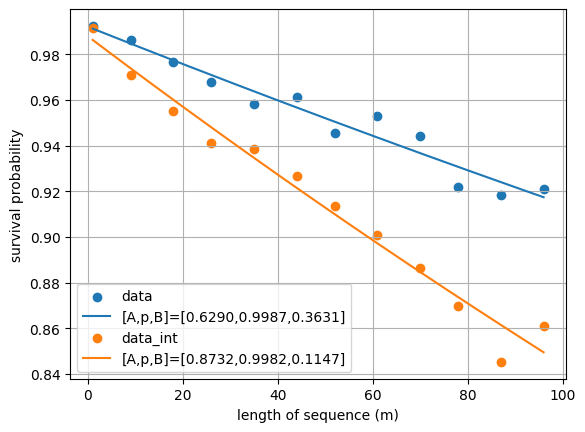

Averaged Clifford Error Rate:    0.065856%
Interleaved Gate Error Rate:     0.024046%


In [93]:
from scipy.optimize import curve_fit

xdata = np.array(trimmers)
ydata = avg_survivalProbs
ydata_int = avg_survivalProbs_int

p0 = [0.5, 1.0, 0.5]

p_opt, p_cov = curve_fit(fun_zeroth_RB, xdata, ydata, p0=p0)
fit_xdata = np.linspace(1,max_length_seq,num=2*max_length_seq)
fit_ydata = [fun_zeroth_RB(x, *p_opt) for x in fit_xdata]

p_opt_int, p_cov = curve_fit(fun_zeroth_RB, xdata, ydata_int, p0=p0)
fit_ydata_int = [fun_zeroth_RB(x, *p_opt_int) for x in fit_xdata]

plt.scatter(xdata, ydata, label='data')
plt.plot(fit_xdata, fit_ydata, label='[A,p,B]=[{:.4f},{:.4f},{:.4f}]'.format(*p_opt))

plt.scatter(xdata, ydata_int, label='data_int')
plt.plot(fit_xdata, fit_ydata_int, label='[A,p,B]=[{:.4f},{:.4f},{:.4f}]'.format(*p_opt_int))

plt.xlabel('length of sequence (m)')
plt.ylabel('survival probability')
plt.legend()
plt.grid()
plt.show()

print("Averaged Clifford Error Rate:{0:>12.6f}%\nInterleaved Gate Error Rate:{1:>13.6f}%".format((1-p_opt[1])/0.02,(1-(p_opt_int[1]/p_opt[1]))/0.02))

### Backend Properties

In [96]:
backend_properties = backend.properties().to_dict()

print('==============================')
print("|      Calibration Data      |")
print('------------------------------')

print("Backend name:", backend_properties['backend_name'])
print("Last calibrated date:", backend_properties['last_update_date'])

for qq in [target_qubit]:
    rdout_err = backend_properties['qubits'][qq][4]['value'] * 100
    id_err = backend_properties['gates'][qq]['parameters'][0]['value'] * 100
    rz_err = backend_properties['gates'][qq+127]['parameters'][0]['value'] * 100
    sx_err = backend_properties['gates'][qq+127*2]['parameters'][0]['value'] * 100
    x_err = backend_properties['gates'][qq+127*3]['parameters'][0]['value'] * 100
    
    print("========================================================================================")
    print("qubit {0} | readout_error (%): {1}".format(qq,rdout_err))
    print("qubit {0} | id_error (%): {1}".format(backend_properties['gates'][qq]['qubits'][0], id_err))
    print("qubit {0} | rz_error (%): {1}".format(backend_properties['gates'][qq+127]['qubits'][0], rz_err))
    print("qubit {0} | sx_error (%): {1}".format(backend_properties['gates'][qq+127*2]['qubits'][0], sx_err))
    print("qubit {0} | x_error (%): {1}".format(backend_properties['gates'][qq+127*3]['qubits'][0],x_err))
                
print('------------------------------')
print("|            Done            |")
print('==============================')

|      Calibration Data      |
------------------------------
Backend name: ibm_sherbrooke
Last calibrated date: 2025-01-04 15:37:00+09:00
qubit 27 | readout_error (%): 0.8199999999999985
qubit 27 | id_error (%): 0.02700792675491292
qubit 27 | rz_error (%): 0
qubit 27 | sx_error (%): 0.02700792675491292
qubit 27 | x_error (%): 0.02700792675491292
------------------------------
|            Done            |


## function trash bin

In [ ]:
def generate_inverse_unitary_gate(qc:QuantumCircuit, sequence: list[int]) -> QuantumCircuit:
    qc_unitary_inverse = qc.copy_empty_like(name='C_u_inv')
    
    unitaries = {0:np.eye(2),
                1:np.array([[0,1],[1,0]]),
                2:np.array([[0,-1j],[1j,0]]),
                3:np.array([[1,0],[0,-1]]),
                4:np.array([[1,1],[1,-1]] / np.sqrt(2)),
                5:np.array([[1,0],[0,1j]]),
                6:np.array([[1,-1],[1,1]] / np.sqrt(2)),
                7:np.array([[-1j,1j],[1j,1j]] / np.sqrt(2)),
                8:np.array([[1,1],[-1,1]] / np.sqrt(2)),
                9:np.array([[0,1j],[1,0]]),
                10:np.array([[0,1],[1j,0]]),
                11:np.array([[1,0],[0,-1j]]),
                12:np.array([[1,0],[0,-1j]]),
                13:np.array([[0,-1j],[1,0]]),
                14:np.array([[0,-1],[1j,0]]),
                15:np.array([[1,0],[0,1j]]),
                16:np.array([[1,1j],[1,-1j]] / np.sqrt(2)),
                17:np.array([[1,1],[1j,-1j]] / np.sqrt(2)),
                18:np.array([[1,-1j],[1,1j]] / np.sqrt(2)),
                19:np.array([[1,1],[-1j,1j]] / np.sqrt(2)),
                20:np.array([[1,-1],[1,1]] / np.sqrt(2)),
                21:np.array([[1,-1j],[1,1j]] / np.sqrt(2)),
                22:np.array([[-1j,1],[1j,1]] / np.sqrt(2)),
                23:np.array([[1,1j],[-1,1j]] / np.sqrt(2))}
    
    inverse_unitary = np.eye(2)
    for g in sequence:
        inverse_unitary = unitaries[g] @ inverse_unitary

    qc_unitary_inverse.unitary(inverse_unitary.conj().T,0)
#    print(type(qc_unitary_inverse))
    
    return qc_unitary_inverse


############
def inverse_map(X: np.array) -> np.array:
    if isUnitary(X):
        return X.conj().T
    return X.conj().T

def isUnitary(X: np.array) -> bool:
    return np.allclose(np.eye(len(X)), X @ X.conj().T)